In [1]:
import tensorflow as tf
import sys
import numpy as np
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
tfm = tfp.models

In [3]:
# Generate synthetic data
inputs = np.arange(2,20,0.2)
outputs = 0.1*np.square(inputs) + 8*np.sin(2*inputs/3) + 2.9*np.random.randn(len(inputs))

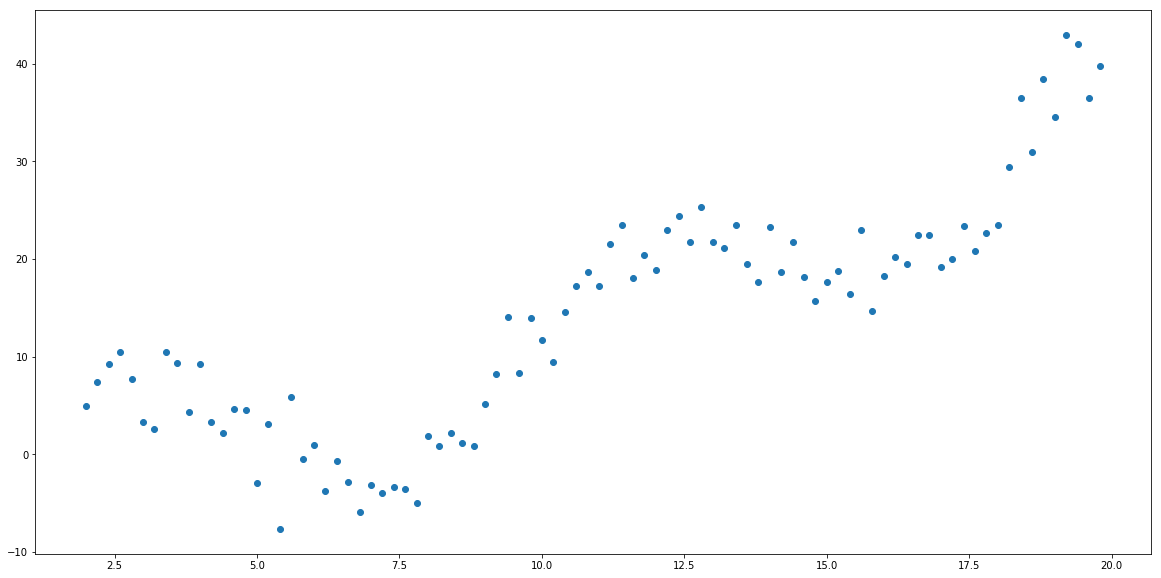

In [4]:
plt.figure(figsize =(20,10))
plt.scatter(inputs,outputs)

In [5]:
# Normalizing the outputs 
mean_y = np.mean(outputs)
std_y = np.std(outputs)
outputsnorm = (outputs - mean_y)/std_y

In [6]:
# normalizing the inputs
mean_x = np.mean(inputs, axis = 0)
std_x = np.std(inputs, axis = 0, keepdims = True)

inputsnorm = (inputs - mean_x)/std_x

scaling_inp = [mean_x, std_x]

In [7]:
model = tfm.BayesianGP(inputs = inputsnorm, outputs = outputsnorm, kernel_type = 'RBF', noise_level = 1e-4)


In [8]:
num_leapfrog_steps = 3
mcmc_samples = 4000
num_warmup_iters = 3000
em_iters = 1000

# HMC sampling

A point estimate for the noise variance is obtained using EM-MCMC

In [9]:
hyperpar_samples,  loss_history,_ = model.EM_with_MCMC(num_warmup_iters = num_warmup_iters, em_iters = em_iters , mcmc_samples = mcmc_samples, num_leapfrog_steps = 3, learning_rate = 0.05)

W0304 19:14:48.459501 139870903351104 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/slot_creator.py:187: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


First warm-up phase.
Warm-Up Iteration:   0 Acceptance Rate: 0.000
Warm-Up Iteration: 200 Acceptance Rate: 0.189
Warm-Up Iteration: 400 Acceptance Rate: 0.352
Warm-Up Iteration: 600 Acceptance Rate: 0.403
Warm-Up Iteration: 800 Acceptance Rate: 0.429
Warm-Up Iteration: 1000 Acceptance Rate: 0.452
Warm-Up Iteration: 1200 Acceptance Rate: 0.460
Warm-Up Iteration: 1400 Acceptance Rate: 0.465
Warm-Up Iteration: 1600 Acceptance Rate: 0.470
Warm-Up Iteration: 1800 Acceptance Rate: 0.474
Warm-Up Iteration: 2000 Acceptance Rate: 0.476
Warm-Up Iteration: 2200 Acceptance Rate: 0.478
Warm-Up Iteration: 2400 Acceptance Rate: 0.479
Warm-Up Iteration: 2600 Acceptance Rate: 0.480
Warm-Up Iteration: 2800 Acceptance Rate: 0.481
Warm-Up Iteration: 2999 Acceptance Rate: 0.481
Estimating the noise variance: 
Iteration:    0 Loss: 22537.572
Iteration:  200 Loss: 552.424
Iteration:  400 Loss: 177.192
Iteration:  600 Loss: 86.064
Iteration:  800 Loss: 52.685
Iteration:  999 Loss: 38.243
Second warm-up phase.

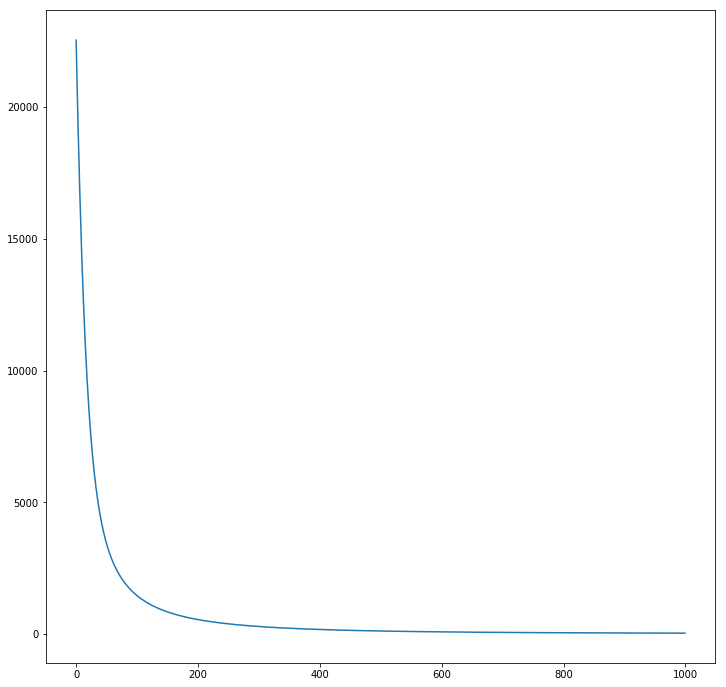

In [10]:
plt.figure(figsize=(12,12))
plt.plot(loss_history)

In [11]:
loc_probs_, varm_probs_, beta_probs_ = hyperpar_samples

Text(0.5, 1.0, 'constant_mean')

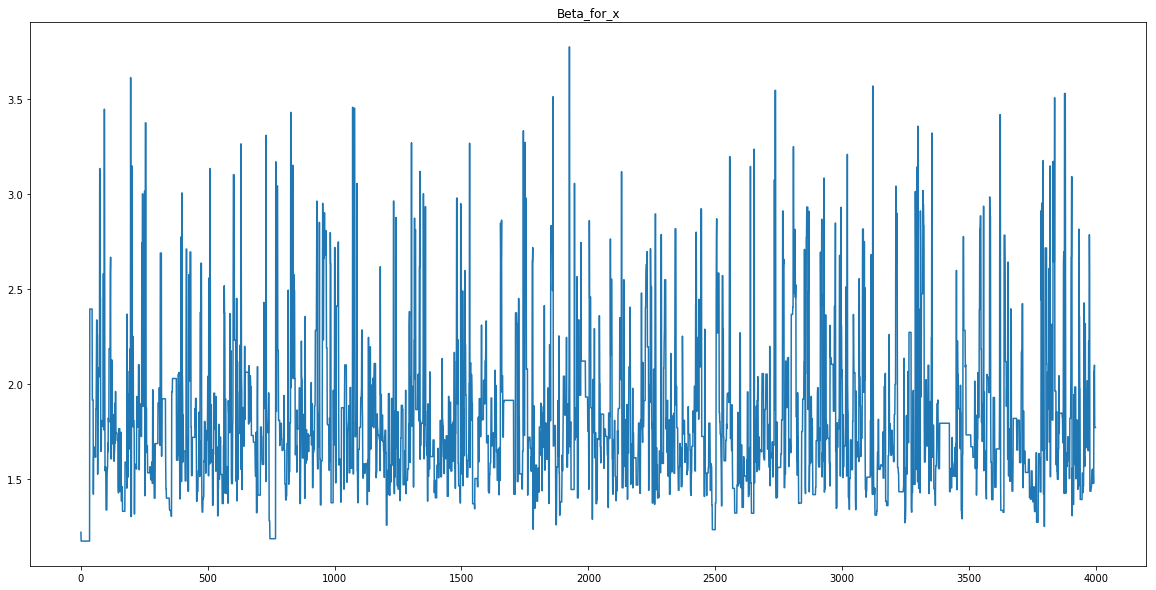

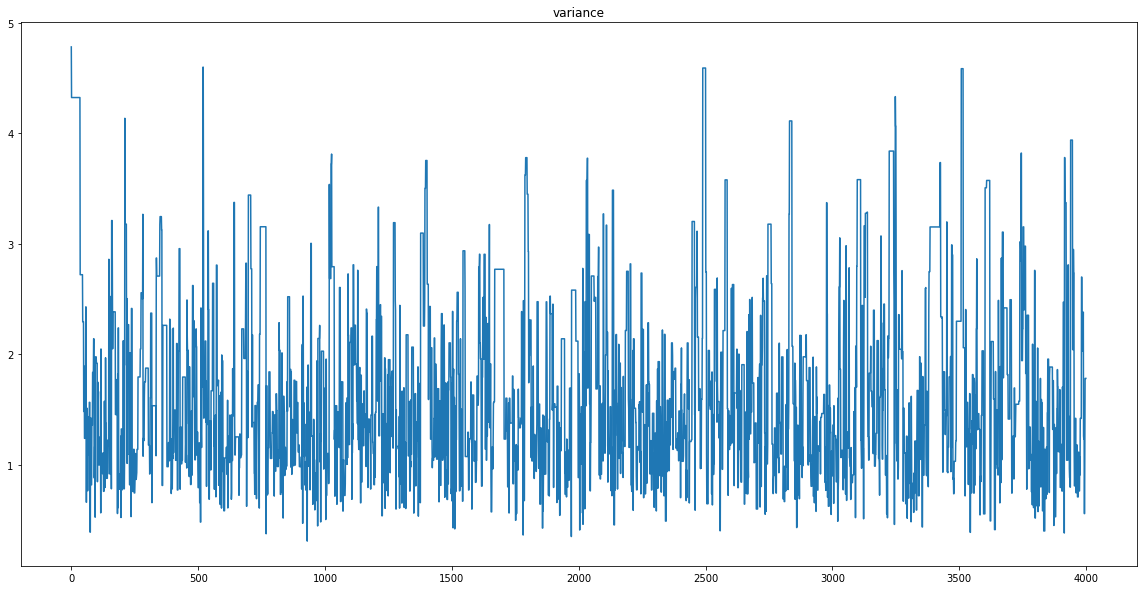

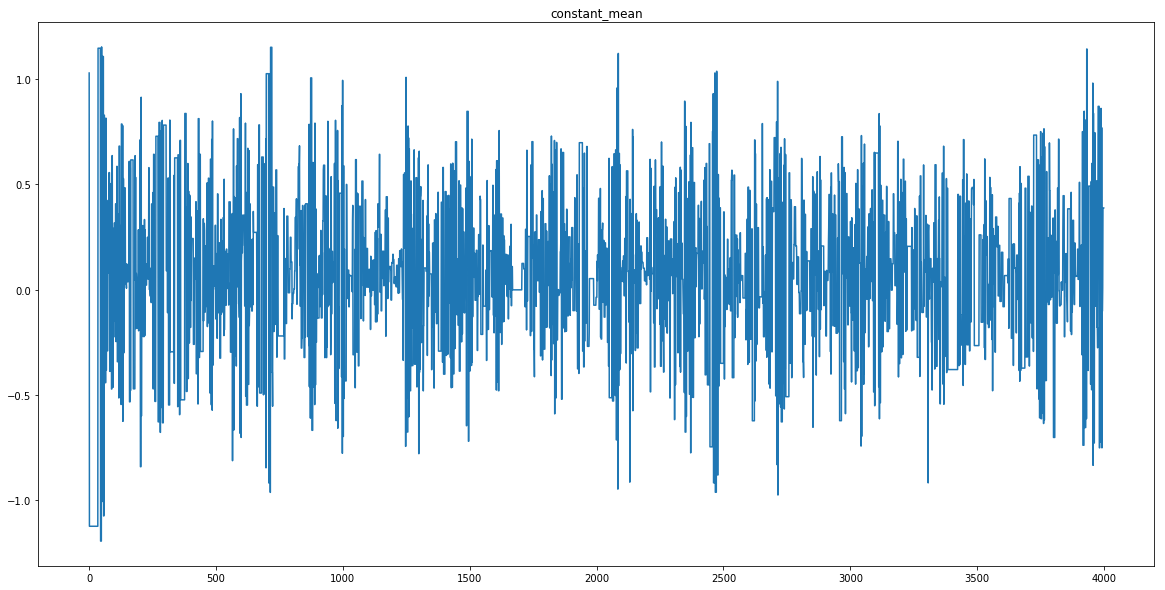

In [12]:
labels = ['x']
n_inputs = 1
# Plotting the chains for the inverse lengthscale 
t = np.arange(mcmc_samples)
for i in range(n_inputs):
    plt.figure(figsize = (20,10))
    plt.plot(t,beta_probs_[:,i])
    title = 'Beta_for_' +  labels[i]
    plt.title(title)
 
    
# Plotting the chains for the variances  
plt.figure(figsize = (20,10))
plt.plot(t,varm_probs_)
title = 'variance'
plt.title(title)



# Plotting the chains for the constant mean function
plt.figure(figsize = (20,10))
plt.plot(t,loc_probs_[:])
title = 'constant_mean'
plt.title(title)


In [13]:
print(model.noise)

0.027716367742640517


In [14]:
print(loc_probs_.shape)
print(varm_probs_.shape)
print(beta_probs_.shape)

(4000,)
(4000,)
(4000, 1)


In [15]:
#inference
# Generating posterior mean, variance of the posterior Gaussian process distribution as well as samples 
mean_pos, var_pos, samples = model.samples(inputsnorm, hyperpar_samples, num_samples = 20, with_point_samples = True)

In [16]:
print(mean_pos.shape)
print(var_pos.shape)
print(samples.shape)

(90,)
(90,)
(80000, 90)


In [17]:
std_pos = np.sqrt(var_pos)  # standard deviation values

In [18]:
# Converting to the right scale
mean_posf = mean_pos*std_y + mean_y 
std_posf = std_pos*std_y 
samplesf = samples*std_y + mean_y

In [19]:
lower = np.percentile(samplesf,2.5, axis = 0)
upper = np.percentile(samplesf,97.5, axis = 0)

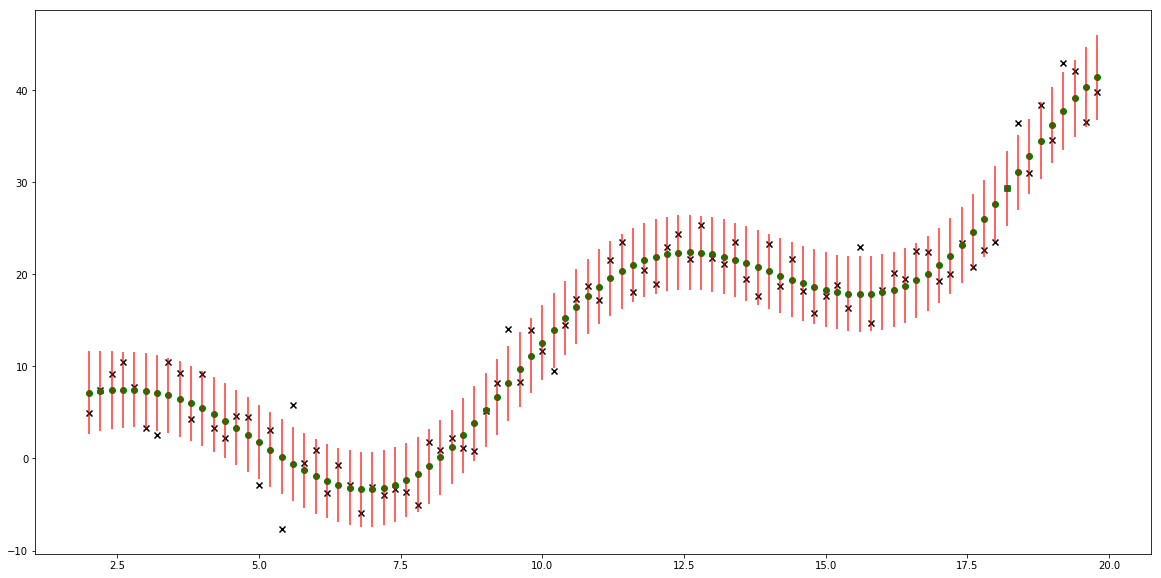

In [20]:
plt.figure(figsize =(20,10))
plt.scatter(inputs,outputs,marker='x', color = 'black', label = 'actual')
plt.scatter(inputs, mean_posf, color = 'green', label = 'predicted')
plt.vlines(inputs, lower, upper, color = 'red', alpha = 0.8)

    
   